# Frequent sub-population testing for COVID-19

_[Boaz Barak](https://boazbarak.org), [Mor Nitzan](https://mornitzan.wixsite.com/nitzan), Neta Ravid Tannenbaum, [Janni Yuval](https://eapsweb.mit.edu/people/janniy)_

[Working paper on arXiv](http://arxiv.org/abs/2007.04827) | [Open this notebook in colab](https://colab.research.google.com/drive/1ZyUylIfo3tSwDHsv942Xl6lgMxAcjGCP?usp=sharing) (see also ["playground" notebook"](https://colab.research.google.com/drive/1pgpVBqchciVYl2qnb6q_L33xLmXogmVo?usp=sharing) ) | [Code on GitHub](https://github.com/boazbk/seirsplus) 

Consider an institution of $N$ people (think business, school, ...) that
was shut down due to COVID-19 and that we would like to open it back up.
_Testing_ will clearly play a significant role in any opening strategy, but what's the best way to use a limited testing budget?

For example, suppose that we have a budget of $N$ tests per month.
Is it better to test all $N$ members of the institution once per month? Ot is it better to test $\approx N/4$ of them per week?
Or perhaps test $N/30$ members per day?
Moreover, if we are smart about testing, could we avoid the added risk to society from
opening the business?

It turns out that it is almost always better to increase the test frequency (e.g., test $25\%$ per week as opposed to $100\%$ per mont),
and sometimes dramatically so,. Moreover, under reasonable assumptions, a moderate amount of frequent testing (coupled with mitigation once an outbreak is detected),
can  __completely offset__ the added risk from opening the business.


In this notebook, we describe this in a simple example. See the [paper](http://arxiv.org/abs/2007.04827)
for more details and this [repository](https://github.com/boazbk/seirsplus) for the code. 

__NOTE:__ This paper has not been yet peer reviewed.

## Setup

Suppose we have an institution of $N=1000$ members, and the prevalence
of COVID-19 in the community is such that each member has probability
$1/5000=0.05\%$ to be infected each day.

(For example,  our own community of
[Cambridge, MA](https://cityofcambridge.shinyapps.io/COVID19/?tab=new)
has about 100K people and the number of daily reported cases has ranged from
$\approx 50$ at the mid April peak to $\approx 2$ recently.
Assuming there are $5$ to $10$ true cases for each reported one,
the daily probability of infection was something like $0.25\%$ to $0.5\%$ at the peak
and is roughly $0.01\%$ to $0.02\%$ now.)

Suppose that if we open up a business, then in expectation each infected member will infect
$R$  individuals within the business, in addition to the people they
will infect in the external society. For example, if each community member infects in expectation $0.9$ people in
external society, and $0.5$ people within their workplace, then opening all businesses can and will
make the difference between controlled and uncontrolled outbreak.

However _testing_ can mitigate this. If we discover an outbreak in a business through randomized testing, we can quarantine
those individuals and ensure they do not continue to infect others.
Moreover, since quarantined individuals also don't infect people in external society,
discovery through workplace testing can cut short their "effective infectious period" and hence
reduce the number of people they would have infected __even compared to the baseline when the workplace was not
open at all!__

We show this using both math (for a simple exponential spread model) and code (building on an SEIR model of [McGee et al](https://github.com/ryansmcgee/seirsplus)).

### Frequent testing outperforms infrequent testing in simulations

Let us run a simulation for the setting we just described.
We use the standard SEIR (suspected-exposed-infected-recovered) model with COVID-19 parameters
taken from the literature. (We expect that as we learn more on COVID-19 and test technology improves, some parameters will change but the
qualitative  conclusions will remain the same; at the moment we assume the mean incubation period is $5.2$ days,
the infectious period is $14$ days, the probability for a false negative for an individual in the incubation period is $67\%$
and is $20\%$ in the infectious period, with no false positives.)

For this particular run, let's assume that each infected person infects on average two people in their workplace.
Here are two execution of such a simulation - the first where we test $100\%$ of the population every $28$ days, and the second where
we test $25\%$ every week. We keep track of the number of __E__xposed, __I__nfected, and __R__ecovered individuals, and stop the
simulation once we get the first positive result.

In [ ]:
%load_ext autoreload
%autoreload 2
from util import * # Python file containing all code, available on https://github.com/boazbk/seirsplus

Test 100% of people every 28 days


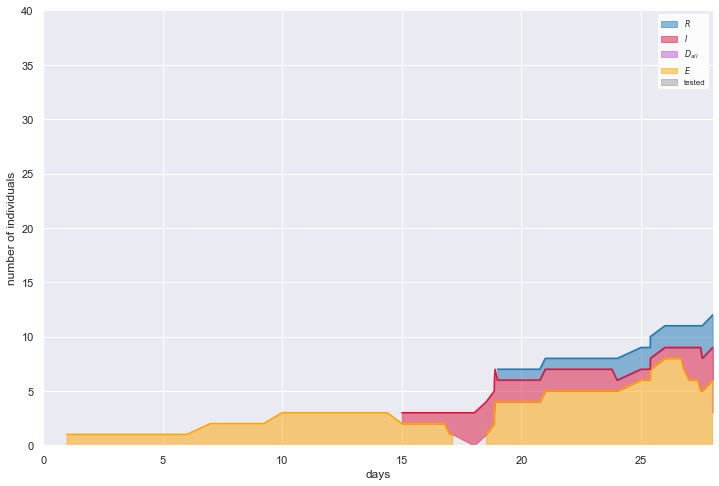

Test 25% of people every 7 days


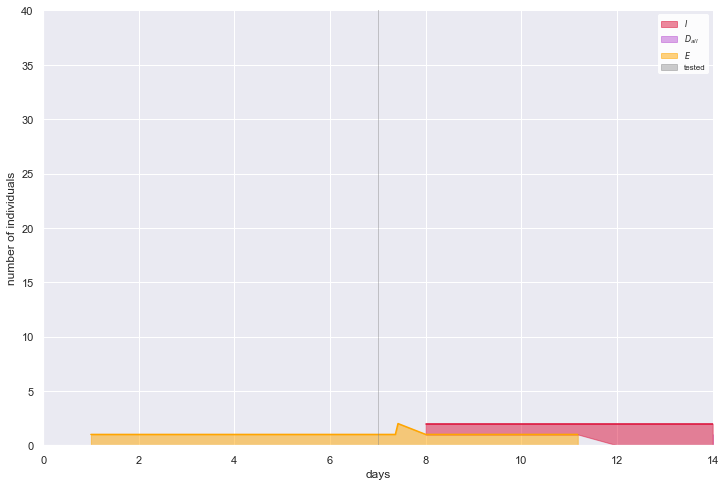

Outbreak detected at 14 days


In [28]:
print("Test 100% of people every 28 days")
sim(base,R=2,period=28,fraction_tested=1);
print("Test 25% of people every 7 days")
log = sim(base,R=2, period=7,fraction_tested=1/4)
print(f"Outbreak detected at {log['t']} days")

In this particular instance, testing every week resulted in discovery of the outbreak at 14 days (the last time we ran this), leading to better outcome. But this does not have to always be the case - there is significant amount of stochasticity here
and sometimes the fact that we only test frequently will cause us to miss an infection.

To compare the two parameter settings, we need to define a cost function. We define the __societal risk__ as
the average number of infected people per day until the first detection.
The rationale is that this corresponds to the number of _infection opportunities_: chances that
for individuals to infect both co-workers and members of the external society until the outbreak
was detected. (We do not model what happens after an outbreak is detected since that would depend
strongly on the particular institution; such detection may a number of mitigation mechanisms including contact tracing, isolation,
temporary closures, widepread testing, and more.)

Let's use a "violin graph" to compare the distribution of this societal risk under both testing regimes.


In [22]:
infrequent = [sim(base,R=2,period=28,fraction_tested=1, plot=False)["risk"] for i in range(50)];
frequent = [sim(base,R=2,period=7,fraction_tested=1/4, plot=False)["risk"] for i in range(50)];


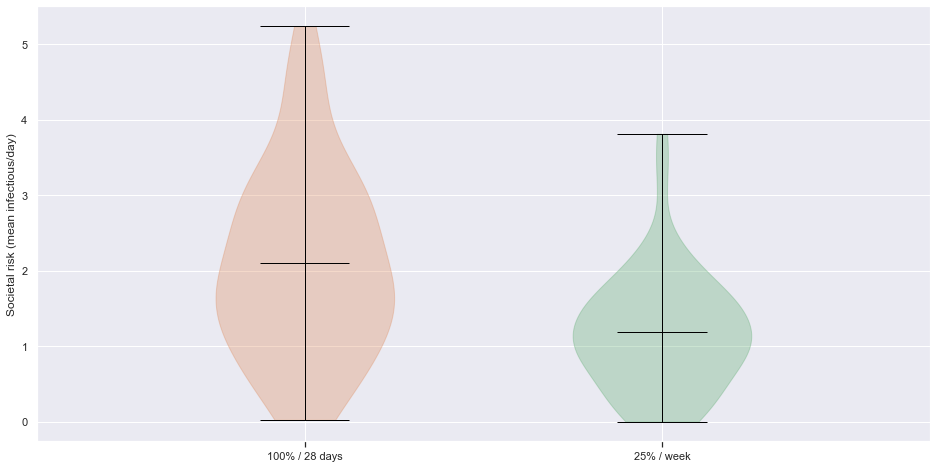

In [4]:
violins([infrequent,frequent], ["100% / 28 days", "25% / week"])

We see that frequent testing reduces the mean social social risk,
but more than that it also significantly drops the "tail" of the distribution - the chance that
the social risk will be much higher than (in this case) an average of 6 infected days.

Moreover, we can also compare to the setting when the business is closed but we don't test at all.

In [5]:
closed = [sim({**base , "T":56 },R=0,period=28,fraction_tested=0, plot=False)["risk"] for i in range(50)];

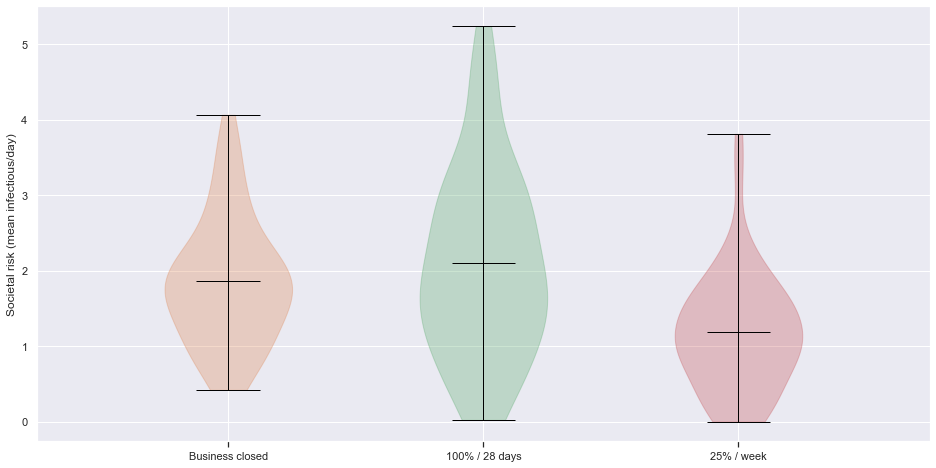

In [6]:
violins([closed,infrequent,frequent], ["Business closed", "100% / 28 days", "25% / week"])

We see that testing $25\%$ of the population per week is not only better than testing everyone
once a week, but in fact even reduces the infection opportunities compared to the baseline
where the business is closed!

Overall this conclusion holds for many (but not all!) parameters for the external infection probability
and internal reproductive number.

![Heat map of performance of 28/4 policy vs. baseline and 28/1](https://raw.githubusercontent.com/boazbk/seirsplus/master/heatmap2.png)

<small>Figure: Comparing the societal risk for the  28/4 testing policy (i.e., 25% each week) against the baseline when business is closed, 28/1 (i.e., 100% every 4 weeks), as well as the case when the business is opened and no testing takes place.
For every value of the external probability and internal reproductive number we track the percentage of the 28/4 risk wrt the comparands (less than 100%  means that 28/4 policy improves on the comparand)
 </small>

### Is more frequent testing always better?

Since we saw that increasing the frequency to once a week gives better outcome,
you might wonder if increasing it even more to daily testing would be even better.
This sometimes is the case, but not always, and regardless we often see rapidly "diminishing returns"
with frequency.

In [7]:
veryfrequent = [sim(base,R=2,period=1,fraction_tested=1/28, plot=False)["risk"] for i in range(50)];

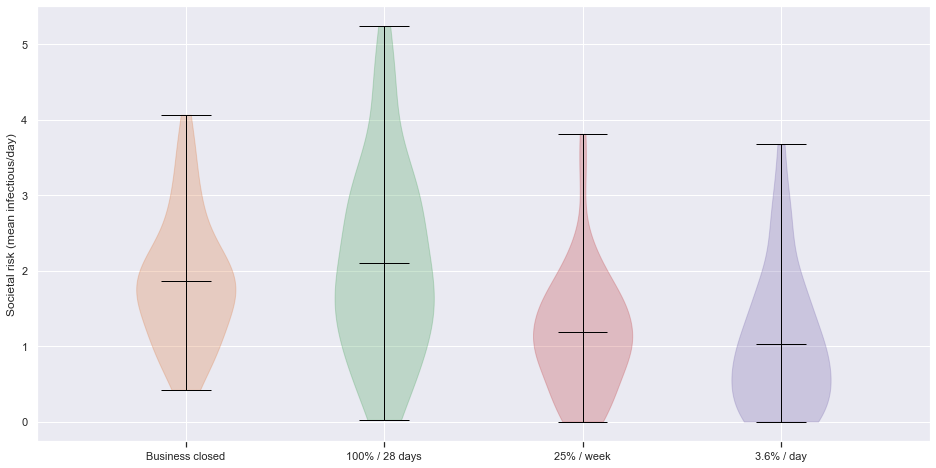

In [8]:
violins([closed,infrequent,frequent, veryfrequent], ["Business closed", "100% / 28 days", "25% / week", "3.6% / day"])


## Can we prove this?

The above are results from simulations, but can we _prove_ that more frequent testing always helps?
To do so, we consider a simpler setting where an initial infection arrives at time $t_0$,
and at time $t-t_0$ there are $C^{t-t_0}$ infected individuals.
The factor $C$ is the growth per time unit (for example, if units are months then $C=10$
might be reasonable for COVID-19, but it of course depends on how well connected is the workplace
or institution).

In this model we ignore factors such as incubation period, false negatives, and simply ask, assuming the following
question: if we have a budget to test $p$ fraction of the individuals per time unit,
and use that by testing $\epsilon p$ fraction every $\epsilon$ time units, what is
the expected number of infected people at detection?

Let's assume $t_0=0$ for simplicity. If at each $\epsilon$ time units we test each individual
with probability $p$ independently, then the probability we will miss  at time $t$ all infected
individuals is  $(1 - \epsilon p)^{C^t}$. The expected risk is the sum over all $n$ of the probability
we missed detection up to time $(n-1)\epsilon$, times the probability we detected at time $n\epsilon$,
times $C^{n \epsilon}$ or in other words

$$\sum_{n=0}^{\infty}  \left( \prod_{i=0}^{n-1} (1 - \epsilon p)^{C^{\epsilon i}} \right) \cdot (1 - (1-\epsilon p)^{C^{\epsilon n}} \cdot C^{\epsilon n}$$

using the formula for arithmetic progressions this is

$$\sum_{n=0}^{\infty}   (1 - \epsilon p)^{(C^{\epsilon n} - 1)(C^\epsilon - 1)}  \cdot (1 - (1-\epsilon p)^{C^{\epsilon n}} \cdot C^{\epsilon n}$$

now letting $\epsilon \rightarrow 0$,  $(1-\epsilon p)^{1/\epsilon} \rightarrow \exp(-p)$,
while $\tfrac{1}{\epsilon}(C^{\epsilon} -1 ) \rightarrow \ln C$
and  $1-(1-\epsilon)^{C^{\epsilon n}} \approx  pC^tdt$ (where $dt = \epsilon$ and $t=\epsilon n$).
Hence the total expected cost converges to the integral

$$\int_{t=0}^\infty \exp(\tfrac{-p(C^t-1)}{\ln C}) p \cdot C^{2t} dt$$

Lucikly, [SymPy](https://www.sympy.org/) knows how to solve this integral 

In [30]:
import sympy as sp
t = sp.Symbol('t')
C = sp.Symbol('C')
p = sp.Symbol('p')
sp.Q.is_true(p>0)
sp.Q.is_true(p<1)
sp.Q.is_true(C>1)
sp.integrate(sp.exp(-p*(C**t - 1)/sp.log(C))*p*C**(2*t),t)

Piecewise(((-C**t*p - log(C))*exp(-p*(C**t - 1)/log(C))/p, Ne(p, 0)), (Piecewise((C**(2*t)*p/(2*log(C)), Ne(2*log(C), 0)), (p*t, True)), True))

Hence the total expected cost equals

$$-\exp\left(\tfrac{p\cdot(1-C^t)}{\ln C}\right)\left( \tfrac{\ln C}{p} + C^t \right)\Bigr|^{t=\infty}_{t=0}  = 1 +\tfrac{\ln C}{p}$$

We see that with frequent enough testing, the cost scales only _logarithmically_ with $C$.
In contrast, consider the case $p=1$. If we test the population every time unit, then
since the initial infection can come at any point, the risk would be $\int_0^1 C^t dt = (C-1)/\ln C$,
which scales _nearly linearly_ with $C$.

However, for small values of $C$, it can be the case that the risk when testing everyone per time period
is lower than the risk in the very frequent setting. However, this difference is limited:
[Wolfram Alpha](https://www.wolframalpha.com/input/?i=max+%281+%2B+ln%28x%29+-+%28x-1%29%2Fln%28x%29%29)
tells us that the maximum of $1 + \ln C - (C-1)/\ln C$ for $C>1$ is $3-e \approx 0.28$.

As usual, see the [paper](http://arxiv.org/abs/2007.04827) for more details. We also created a ["playground" notebook"](https://colab.research.google.com/drive/1pgpVBqchciVYl2qnb6q_L33xLmXogmVo?usp=sharing) where you can test out simulations of different scenarios
